In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis,get_time_plate_info_long_from_analysis 
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import logging
import warnings

logging.getLogger().setLevel(logging.WARNING)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plates = ['94_20201123']
plate_select = [94]

C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def select_movement(plate_id, time_hypha_info, min_num_occ=1):
    time_hypha_plate = time_hypha_info.loc[time_hypha_info["unique_id"] == plate_id]
    select = time_hypha_plate
    max_speeds = select.groupby("end").max()["speed"]
    correct_tracks = max_speeds.loc[max_speeds <= 450]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select = select.loc[select["distance_final_pos"] >= 1500]
    select = select.loc[select["speed"].between(50, 400)]
    select = select.loc[select["in_ROI"] == "True"]
    num_occ = select.groupby("end").count()["speed"]
    correct_tracks = num_occ.loc[num_occ >= min_num_occ]
    select = select.loc[select["end"].isin(correct_tracks.index)]
    select_movements = select
    return select_movements


def get_average_time_data(plate_id, time_hypha_info, min_num_occ=1):
    select_movements = select_movement(plate_id, time_hypha_info, min_num_occ)
    group = select_movements.groupby(["time_since_begin_h"])["speed"]
    data = group.median()
    dy = group.std() / np.sqrt(group.count())

    return (data, dy, select_movements)

In [3]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)


In [4]:
plate_id = '94_20201123'
plate_id_int = int(plate_id)
data,dy,select_movements = get_average_time_data(plate_id_int,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
timesteps = []
hypha_hulls = []
for timestep in hyphae_hull.keys():
    line = hyphae_hull[timestep]
    timesteps += [timestep for hyph in line]
    hypha_hulls += [hyph for hyph in line]
data_front = pd.DataFrame((np.array((timesteps,hypha_hulls))).transpose(),columns=('timestep','label'))
data_front['timestep_label'] = data_front['timestep'].astype(str)+data_front['label'].astype(str)
select_movements['group_time'] = select_movements['timestep']//10
select_movements['timestep_label'] = select_movements['timestep'].astype(str)+select_movements['end'].astype(str)

select_movements['is_hull_pusher'] = select_movements["timestep_label"].isin(data_front['timestep_label'])
select = select_movements.loc[select_movements['timestep']<100]

Text(0, 0.5, '$cos(\\theta-\\theta_0)$')

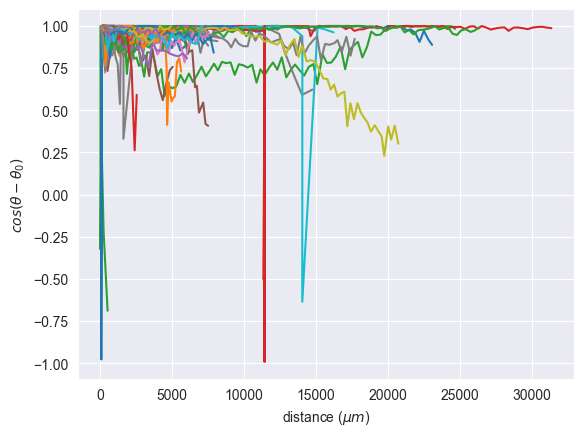

In [5]:
fig,ax = plt.subplots()
select_hyphae = select_movements.loc[select_movements['timestep']<100]

select_hyphae = select_movements.loc[select_movements['speed']>200].copy()
vecs_lists = []    
# for j,hyph in enumerate([0,  118, 58, 1]):
for j,hyph in enumerate(select_hyphae['end'].unique()):
    select_hypha = select_movements.loc[select_movements['end']==hyph]
#     select_hypha = select_hypha.loc[select_hypha['timestep']<100]
    
#     select_hypha = select_hypha.loc[select_hypha['speed']>200].copy()
    

    select_hypha = select_hypha.sort_values('timestep')
    vecx,vecy = select_hypha['pos_x'].diff(1),select_hypha['pos_y'].diff(1)
    vecx_norm = vecx/(vecx**2+vecy**2)**(1/2)
    vecy_norm = vecy/(vecx**2+vecy**2)**(1/2)
    persistence = vecx_norm.iloc[1]*vecx_norm+vecy_norm.iloc[1]*vecy_norm
    dists = np.sqrt((select_hypha['pos_x']-select_hypha['pos_x'].iloc[0])**2+(select_hypha['pos_y']-select_hypha['pos_y'].iloc[0])**2)*1.725
    vecs_lists.append((dists.values,vecx_norm.iloc[1:].values,vecy_norm.iloc[1:].values))
    ax.plot(dists,persistence)
ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel(r'$cos(\theta-\theta_0)$')

Text(0, 0.5, '$sin(\\theta-\\theta_0)$')

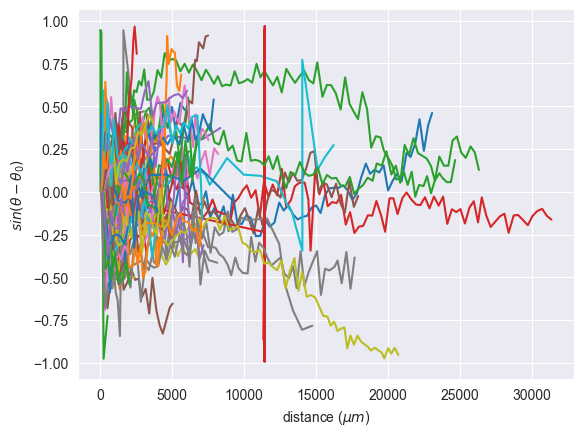

In [6]:
fig,ax = plt.subplots()
select_hyphae = select_movements.loc[select_movements['timestep']<100]

select_hyphae = select_movements.loc[select_movements['speed']>200].copy()
vecs_lists = []    
# for j,hyph in enumerate([0,  118, 58, 1]):
for j,hyph in enumerate(select_hyphae['end'].unique()):
    select_hypha = select_movements.loc[select_movements['end']==hyph]
#     select_hypha = select_hypha.loc[select_hypha['timestep']<100]
    
#     select_hypha = select_hypha.loc[select_hypha['speed']>200].copy()
    

    select_hypha = select_hypha.sort_values('timestep')
    vecx,vecy = select_hypha['pos_x'].diff(1),select_hypha['pos_y'].diff(1)
    vecx_norm = vecx/(vecx**2+vecy**2)**(1/2)
    vecy_norm = vecy/(vecx**2+vecy**2)**(1/2)
    persistence = vecx_norm.iloc[1]*vecy_norm-vecy_norm.iloc[1]*vecx_norm
    dists = np.sqrt((select_hypha['pos_x']-select_hypha['pos_x'].iloc[0])**2+(select_hypha['pos_y']-select_hypha['pos_y'].iloc[0])**2)*1.725
    vecs_lists.append((dists.values,vecx_norm.iloc[1:].values,vecy_norm.iloc[1:].values))
    ax.plot(dists,persistence)
ax.set_xlabel('distance ($\mu m$)')
ax.set_ylabel(r'$sin(\theta-\theta_0)$')

In [8]:
def exp_func(x, a):
    return np.exp(-x / a)

Text(0, 0.5, '$\\langle \\cos(\\Delta \\theta) \\rangle$')

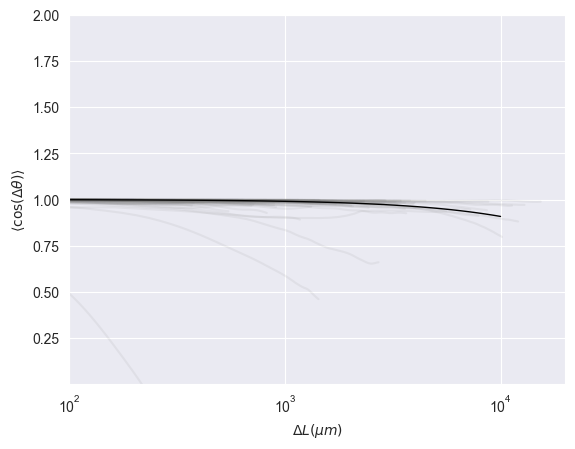

In [9]:
fig,ax = plt.subplots()
# fig,ax = plt.subplots()

correlation_length = []
for k in range(len(vecs_lists)):
    dist = vecs_lists[k][0][1:]
    vecx = vecs_lists[k][1]
    vecy = vecs_lists[k][2]
    if len(vecx)>4:
        # Generate new regularly spaced x
        new_dist = np.linspace(start=dist.min(), stop=dist.max(), num=100)  # for instance, 100 points

        # Interpolate y values at new x
        new_vecx = np.cos(np.interp(new_dist, dist, np.arccos(vecx)))

        # Interpolate y values at new x
        new_vecy = np.sin(np.interp(new_dist, dist, np.arcsin(vecy)))

        correlation_func = np.zeros(len(new_vecx))

        # Compute the correlation function
        for i in range(len(new_vecx)):
            for j in range(i, len(new_vecx)):
                # Compute the cosine of the angle between the tangents
                cos_theta = new_vecx[i]*new_vecx[j]+new_vecy[i]*new_vecy[j]
                # Add to the correlation function
                correlation_func[j-i] += cos_theta

        # Average the correlation function
        correlation_func /= np.arange(len(new_vecx), 0, -1)
        popt, pcov = curve_fit(exp_func,new_dist[:len(new_vecx)//2]-new_dist[0], correlation_func[:len(new_vecx)//2],p0=[5000])
        correlation_length.append(popt[0])
        ax.plot(new_dist[:len(new_vecx)//2]-new_dist[0],correlation_func[:len(new_vecx)//2],color="grey",alpha = 0.1)
        xs = new_dist[:len(new_vecx)//2]-new_dist[0]
        # ax.plot(xs,np.exp(-xs/popt[0]))        
        # break
ax.set_xscale("log")
# ax.set_yscale("log")

xs = np.linspace(1e1,1e4,100)
ax.set_xlim(1e2,2e4)
ax.set_ylim(1e-4,2)

ax.plot(xs,np.exp(-xs/np.median(correlation_length)),color="black",linewidth=1)
ax.set_xlabel('$\Delta L(\mu m)$')
ax.set_ylabel('$\\langle \\cos(\Delta \\theta) \\rangle$')


In [11]:
rh_angle = np.load('data/rh_angle.npy')
bas_angle = np.load('data/bas_angle.npy')

Text(0, 0.5, 'branching angle (°)')

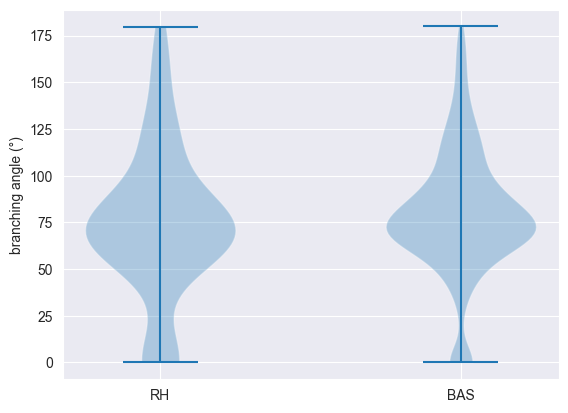

In [12]:
fig,ax = plt.subplots()

ax.violinplot([np.abs(rh_angle),np.abs(bas_angle)])
ax.set_xticks([1, 2])
ax.set_xticklabels(['RH', 'BAS'])
ax.set_ylabel('branching angle (°)')
